In [55]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.mask import mask
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

import os

In [56]:
# Função para converter valores nodata para NaN
def convert_nodata_to_nan(array, nodata_value):
    array = np.where(array == nodata_value, np.nan, array)
    return array

In [57]:
# Função para extrair valores médios das bandas para cada geometria
def extract_mean_band_values(gdf, tif_paths):
    features = []
    for geom in gdf.geometry:
        band_means = []
        for color, path in tif_paths.items():
            with rasterio.open(path) as src:
                band_masked, _ = mask(src, [geom], crop=True)
                band_values = band_masked.flatten()
                band_values = convert_nodata_to_nan(band_values, src.nodata)
                band_means.append(np.nanmean(band_values))
        features.append(band_means)
    return np.array(features)

In [58]:
# Diretórios de entrada e saída
input_shapefile = '/home/andre/Documentos/SpotSat/data/raw/shape_validation/pontos_valid.shp'
input_tif_files = {
    'red': '/home/andre/Documentos/SpotSat/data/raw/tif_files/red.tif',
    'green': '/home/andre/Documentos/SpotSat/data/raw/tif_files/green.tif',
    'blue': '/home/andre/Documentos/SpotSat/data/raw/tif_files/blue.tif'
}
output_directory = '/home/andre/Documentos/SpotSat/data/processed/valid'

In [59]:
# Carregar shapefile de treinamento
validation_gdf = gpd.read_file(input_shapefile)

# Verificar e explorar os dados do shapefile
print(validation_gdf.info())
print(validation_gdf.head())
print(validation_gdf.describe())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        132 non-null    float64 
 1   LULC      132 non-null    int64   
 2   geometry  132 non-null    geometry
dtypes: float64(1), geometry(1), int64(1)
memory usage: 3.2 KB
None
    id  LULC                     geometry
0  0.0     0  POINT (-48.57153 -20.87367)
1  1.0     1  POINT (-48.40954 -21.04531)
2  2.0     0  POINT (-48.79813 -20.70012)
3  3.0     1  POINT (-48.72556 -20.74687)
4  4.0     0  POINT (-49.46797 -20.56219)
               id        LULC
count  132.000000  132.000000
mean    66.265152    0.500000
std     39.024138    0.501905
min      0.000000    0.000000
25%     32.750000    0.000000
50%     66.000000    0.500000
75%    100.250000    1.000000
max    133.000000    1.000000


In [60]:
print(validation_gdf.is_valid)


0      True
1      True
2      True
3      True
4      True
       ... 
127    True
128    True
129    True
130    True
131    True
Length: 132, dtype: bool


In [61]:
overlaps = validation_gdf.geometry.apply(lambda geom: validation_gdf.geometry.overlaps(geom))
print(overlaps)


       0      1      2      3      4      5      6      7      8      9    \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
127  False  False  False  False  False  False  False  False  False  False   
128  False  False  False  False  False  False  False  False  False  False   
129  False  False  False  False  False  False  False  False  False  False   
130  False  False  False  False  False  False  False  False  False  False   
131  False  False  False  False  False  False  False  False  False  False   

     ...    122    123    124    125    126    127    128    129    130    

Red Band:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7668, 'height': 5035, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00017966223265519074, 0.0, -49.66228,
       0.0, -0.00017966236345580904, -20.24569)}


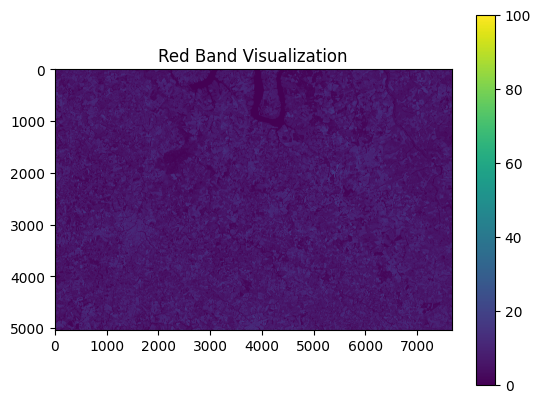

Green Band:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7668, 'height': 5035, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00017966223265519074, 0.0, -49.66228,
       0.0, -0.00017966236345580904, -20.24569)}


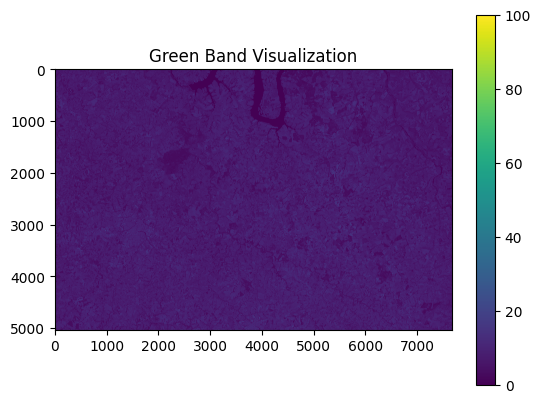

Blue Band:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 7668, 'height': 5035, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00017966223265519074, 0.0, -49.66228,
       0.0, -0.00017966236345580904, -20.24569)}


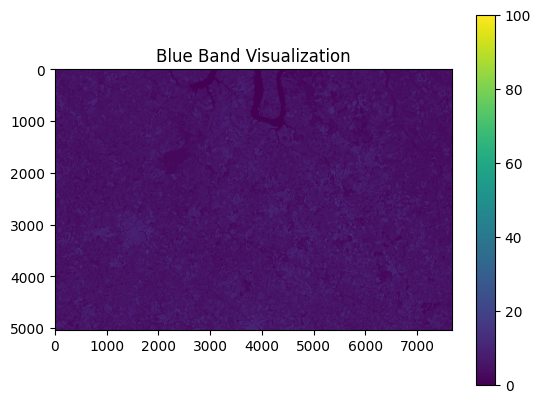

In [62]:
# Exploração inicial dos TIF files
for color, path in input_tif_files.items():
    with rasterio.open(path) as src:
        print(f'{color.capitalize()} Band:')
        print(src.meta)
        plt.imshow(src.read(1), cmap='viridis')
        plt.title(f'{color.capitalize()} Band Visualization')
        plt.colorbar()
        plt.show()

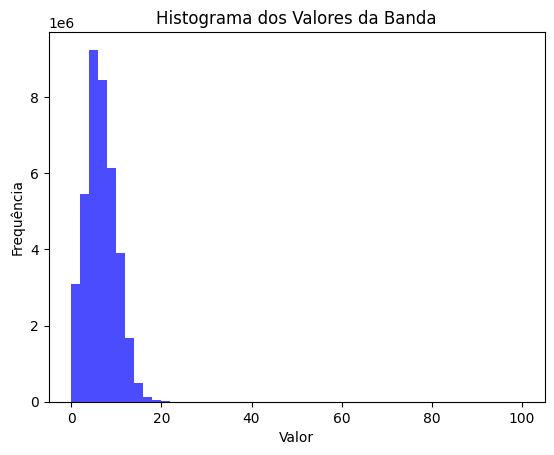

In [63]:
with rasterio.open('/home/andre/Documentos/SpotSat/data/raw/tif_files/red.tif') as src:
    plt.hist(src.read(1).flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Histograma dos Valores da Banda")
    plt.xlabel("Valor")
    plt.ylabel("Frequência")
    plt.show()


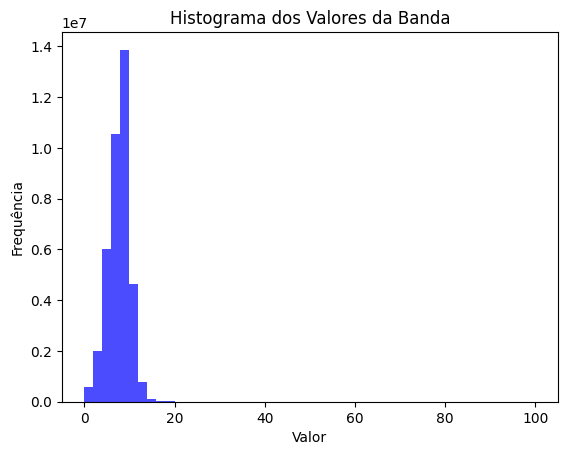

In [64]:
with rasterio.open('/home/andre/Documentos/SpotSat/data/raw/tif_files/green.tif') as src:
    plt.hist(src.read(1).flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Histograma dos Valores da Banda")
    plt.xlabel("Valor")
    plt.ylabel("Frequência")
    plt.show()


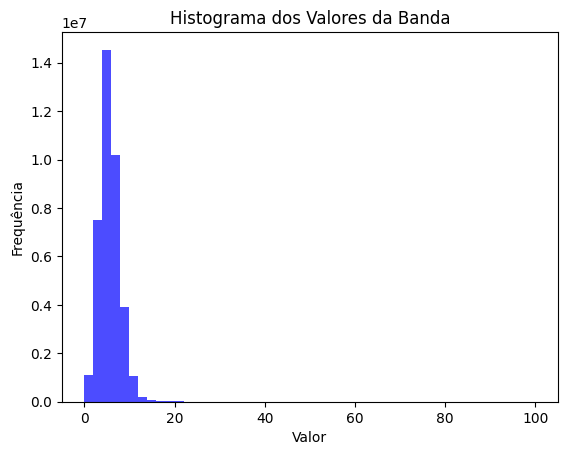

In [65]:
with rasterio.open('/home/andre/Documentos/SpotSat/data/raw/tif_files/blue.tif') as src:
    plt.hist(src.read(1).flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Histograma dos Valores da Banda")
    plt.xlabel("Valor")
    plt.ylabel("Frequência")
    plt.show()


In [66]:
# Extrair valores médios de cada banda para o shapefile de treinamento
X_train = extract_mean_band_values(validation_gdf, input_tif_files)

In [67]:
# Contar quantos NaN existem em X_train
total_nan = np.isnan(X_train).sum()
print(f"Número total de NaN em X_train: {total_nan}")

Número total de NaN em X_train: 0


In [68]:
# Tratar NaNs (substituir pela mediana)
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)

In [69]:
np.save(output_directory + 'X_train_processed.npy', X_train)

In [70]:
X_train = np.load(output_directory + 'X_train_processed.npy')
print(X_train.shape)

(132, 3)


In [71]:
validation_gdf.to_file(os.path.join(output_directory, 'validation_gdf_processed.shp'))


In [72]:
validation_gdf_loaded = gpd.read_file(os.path.join(output_directory, 'validation_gdf_processed.shp'))
print(validation_gdf_loaded.head())


    id  LULC                     geometry
0  0.0     0  POINT (-48.57153 -20.87367)
1  1.0     1  POINT (-48.40954 -21.04531)
2  2.0     0  POINT (-48.79813 -20.70012)
3  3.0     1  POINT (-48.72556 -20.74687)
4  4.0     0  POINT (-49.46797 -20.56219)
